# Analysis of factors influencing books prices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import scipy.stats as stats
from googletrans import Translator

The dataset used in this analysis is scraped with help of Scrapy. 

[The spider can be also found on ScrapingHub here](https://app.scrapinghub.com/p/457074/1)

The target page was swiatksiazki.pl, the subpages were limited to those listing books alone, audiobooks and ebooks not included.

In [2]:
df = pd.read_csv('books.csv')

In [3]:
df[:5]

,categories,cover,date_published,ean,pages_count,price,price_old,publisher,series,size_cm,title
0,Książki / proza / proza obca,okładka miękka,2020-06-03,9788381394093,480.0,"26,73 zł","39,90 zł",Świat Książki,Kolekcja dzieł Kristin Hannah,13.5 x 21.5,Prawdziwe kolory
1,"Książki / biografie / postacie historyczne, po...",okładka miękka,2020-05-20,9788324077939,412.0,"26,15 zł","39,99 zł",Znak,NaN,13.5x20.5,Pani Churchill
2,Książki / kryminał i sensacja / kryminałKsiążk...,okładka miękka,2020-05-06,9788366500167,384.0,"28,73 zł","39,90 zł",Marginesy,NaN,13.5 x 21.0,Wyrwa
3,Książki / literatura faktu / polityka i polito...,okładka miękka,2020-05-13,9788364076954,360.0,"25,94 zł","39,99 zł",Polityka,NaN,14x20.5,"W Polsce, czyli wszędzie. Rzecz o upadku i prz..."
4,Książki / fantastyka / fantasy,okładka miękka,2020-05-20,9788328052062,560.0,"31,99 zł","39,99 zł",Uroboros,NaN,13.5 x 20,Dom Ziemi i Krwi. Część 1. Cykl Księżycowe mia...


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71441 entries, 0 to 71440
Data columns (total 11 columns):
categories        71441 non-null object
cover             66920 non-null object
date_published    71429 non-null object
ean               71441 non-null int64
pages_count       68194 non-null float64
price             71441 non-null object
price_old         66528 non-null object
publisher         71431 non-null object
series            5515 non-null object
size_cm           69426 non-null object
title             71441 non-null object
dtypes: float64(1), int64(1), object(9)
memory usage: 6.0+ MB


## Data cleaning
### Converting columns to correct formats

The first column contains string with all categories a book was assigned to. It's unordered but it's uniform pattern makes it easier to properly split relevant information. The first part of the string always indicates if a book was written in/translated to Polish ('książki') or not ('książki obcojęzyczne').

In [5]:
df['isPolish'] = df.categories.str.split(' / ').str[0].str.lower()
df['isPolish'] = np.where(df['isPolish']=='książki', 1, 0)
df[df['isPolish'] == 0][:5]

,categories,cover,date_published,ean,pages_count,price,price_old,publisher,series,size_cm,title,isPolish
27,książki obcojęzyczne / angielskie / Fiction,okładka twarda,2020-04-02,9781529123944,336.0,"61,50 zł","67,90 zł",Cornerstone,NaN,22.2x14.6,The Silent Treatment,0
44,książki obcojęzyczne / angielskie / Fiction,okładka miękka,NaN,9781853261770,NaN,"13,00 zł","13,90 zł",Wordsworth Editions,NaN,198 x 126 mm,The Portrait of a Lady (Wordsworth Classics),0
58,książki obcojęzyczne / angielskie / Fiction,okładka miękka,2020-06-25,9781838771164,448.0,"42,50 zł","46,90 zł",Bonnier Zaffre,NaN,12.9x19.8,The Catch,0
73,książki obcojęzyczne / angielskie / Children's,okładka twarda,2018-09-06,9781786961037,112.0,"62,50 zł","68,90 zł",Bonnier Zaffre,NaN,22.7x20.9,Bear Grylls Epic Adventures Series - Epic Flights,0
100,książki obcojęzyczne / angielskie / Children's,okładka miękka,2020-04-16,9780241440766,160.0,"38,00 zł","41,90 zł",Penguin Books Ltd,NaN,12.9x17.8,The Call of the Wild (Green Puffin Classics),0


The rest of the string contains information about other categories, however the further the part, the most specific the subject is, which makes it harder to properly assign a book to a broader category. 

In [6]:
cats = df.categories.str.split(' / ')
cats_max = cats.apply(lambda x: len(x)).max()
for i in range(1,cats_max):
    print(len(set(df.categories.str.split(' / ').str[i])))

72
486
313
359
164
257
71
66
52
16
15
20
3
6
6
2
3
3
2


The second part of the string seems to fit the most as the number of different isn't either too great or too small. 

In [7]:
cats.str[1].str.lower().value_counts()

angielskie                              25235
dla dzieci                               6632
proza                                    5696
outlet                                   3520
poradniki                                3122
                                        ...  
kultura i sztukaksiążki obcojęzyczne        1
angielskieksiążki obcojęzyczne              1
inneksiążki obcojęzyczne                    1
dla młodzieżyksiążki obcojęzyczne           1
dla dzieciksiążki                           1
Name: categories, Length: 71, dtype: int64

There is also an issue that requires fixing - some of the entries were immidiately followed by the new set of categories and were extracted as one string as a result. Those entires also impact the true amount of subcategories and will be corrected by replacing a part next category set with an empty string.

In [8]:
df['subject'] = cats.str[1].str.lower().replace(r'książki$|książki obcojęzyczne$', '', regex=True)
df['subject'].fillna(df.subject.mode()[0], inplace=True)

In [9]:
len(df['subject'].value_counts())

40

In [10]:
df['subject'].value_counts()

angielskie                     25487
dla dzieci                      6633
proza                           5696
outlet                          3564
poradniki                       3122
kryminał i sensacja             2541
historia                        2238
literatura faktu                2164
biografie                       2030
dla młodzieży                   1651
nauki humanistyczne             1605
podróże                         1545
audiobook                       1311
prawo                           1198
fantastyka                      1196
religia                         1186
proza obyczajowa                1154
komiksy                          956
biznes                           893
informatyka                      866
poezja i dramat                  801
albumy                           724
kultura i sztuka                 671
nauka języków                    484
polscy autorzy                   423
nauki ścisłe                     279
niemieckie                       206
l

For the readability and cosistence, the subjects will be translated into English. I will create the list of subjects, translate it and then map it with the actual series in order not to exceed the daily limit usage.

In [11]:
subj = df['subject'].to_list()
subj_list = sorted(list(set(subj)))
translator = Translator()
subj_list_trans = [translator.translate(x, src='pl').text for x in subj_list]
subj_list_trans = ['law' if x=='right' else x for x in subj_list_trans]
dictionary = dict(zip(subj_list, subj_list_trans))
df['subject'] = df['subject'].map(dictionary)
df['subject'] = df['subject'].str.lower().astype('category')
df.drop('categories', axis=1, inplace=True)

In [12]:
df[:5]

,cover,date_published,ean,pages_count,price,price_old,publisher,series,size_cm,title,isPolish,subject
0,okładka miękka,2020-06-03,9788381394093,480.0,"26,73 zł","39,90 zł",Świat Książki,Kolekcja dzieł Kristin Hannah,13.5 x 21.5,Prawdziwe kolory,1,prose
1,okładka miękka,2020-05-20,9788324077939,412.0,"26,15 zł","39,99 zł",Znak,NaN,13.5x20.5,Pani Churchill,1,biographies
2,okładka miękka,2020-05-06,9788366500167,384.0,"28,73 zł","39,90 zł",Marginesy,NaN,13.5 x 21.0,Wyrwa,1,crime and sensation
3,okładka miękka,2020-05-13,9788364076954,360.0,"25,94 zł","39,99 zł",Polityka,NaN,14x20.5,"W Polsce, czyli wszędzie. Rzecz o upadku i prz...",1,non-fiction
4,okładka miękka,2020-05-20,9788328052062,560.0,"31,99 zł","39,99 zł",Uroboros,NaN,13.5 x 20,Dom Ziemi i Krwi. Część 1. Cykl Księżycowe mia...,1,fantastic


Next, the cover - I have decided to distinguish between soft and hard cover only and treat other types as nan, as their quantity is not great enough to give a reliable result.

In [13]:
df.cover.value_counts()

okładka miękka         44430
okładka twarda         20118
etui                    1438
oprawa zintegrowana      916
PCV                        6
zintegrowana               6
pcv                        2
miękka z tworzywa          2
CD+książka                 1
plastikowa                 1
Name: cover, dtype: int64

In [14]:
conditions = [
    df['cover'] == 'okładka miękka',
    df['cover'] == 'okładka twarda',
    ]
choices = [0, 1]

df['cover'] = np.select(conditions, choices, default=np.nan).astype(int)

The price needs to be sanitized and turned into float values.

In [15]:
df['price'] = df['price'].str.replace(' zł', '').str.replace(',', '.').str.replace(' ', '').astype(float)
df['price_old'] = df['price_old'].str.replace(' zł', '').str.replace(',', '.').astype(float)

The size columns contains both width and height of a book. Some fo them seem to be presented in mm, as are unusually large (4 digit numbers). In order to maintain consitency, the values will be converted to cm.

In [16]:
df['width'] = df['size_cm'].str.findall(r'(\d+\.?\d)').str[0]
df['height'] = df['size_cm'].str.findall(r'(\d+\.?\d)').str[1]
df['width'] = df['width'].astype(float)
df['height'] = df['height'].astype(float)
df.drop('size_cm', axis=1, inplace=True)

In [17]:
df.loc[df['width'].astype(str).str.findall(r'(\d+)').str[0].str.len() > 2, 'width'] = df['width']/10
df.loc[df['width'].astype(str).str.findall(r'(\d+)').str[0].str.len() > 2, 'width'] = df['width']/10

In [18]:
df.loc[df['height'].astype(str).str.findall(r'(\d+)').str[0].str.len() > 2, 'height'] = df['height']/10
df.loc[df['height'].astype(str).str.findall(r'(\d+)').str[0].str.len() > 2, 'height'] = df['height']/10

Finally, date published will be coverted to datetime values.

In [19]:
df['date_published'] = pd.to_datetime(df['date_published'])

In [20]:
df[:5]

,cover,date_published,ean,pages_count,price,price_old,publisher,series,title,isPolish,subject,width,height
0,0,2020-06-03,9788381394093,480.0,26.73,39.90,Świat Książki,Kolekcja dzieł Kristin Hannah,Prawdziwe kolory,1,prose,13.5,21.5
1,0,2020-05-20,9788324077939,412.0,26.15,39.99,Znak,NaN,Pani Churchill,1,biographies,13.5,20.5
2,0,2020-05-06,9788366500167,384.0,28.73,39.90,Marginesy,NaN,Wyrwa,1,crime and sensation,13.5,21.0
3,0,2020-05-13,9788364076954,360.0,25.94,39.99,Polityka,NaN,"W Polsce, czyli wszędzie. Rzecz o upadku i prz...",1,non-fiction,14.0,20.5
4,0,2020-05-20,9788328052062,560.0,31.99,39.99,Uroboros,NaN,Dom Ziemi i Krwi. Część 1. Cykl Księżycowe mia...,1,fantastic,13.5,20.0


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71441 entries, 0 to 71440
Data columns (total 13 columns):
cover             71441 non-null int32
date_published    71429 non-null datetime64[ns]
ean               71441 non-null int64
pages_count       68194 non-null float64
price             71441 non-null float64
price_old         66528 non-null float64
publisher         71431 non-null object
series            5515 non-null object
title             71441 non-null object
isPolish          71441 non-null int32
subject           71441 non-null category
width             68442 non-null float64
height            68403 non-null float64
dtypes: category(1), datetime64[ns](1), float64(5), int32(2), int64(1), object(3)
memory usage: 6.1+ MB


### Missing values
Missing values are a very small portion of the whole dataset (except for the 'series' column, which is not essential). These nans will be filled by either mean or mode of the column.

In [22]:
df.date_published.fillna(df.date_published.mode()[0], inplace=True)
df.pages_count.fillna(round(df.pages_count.mean()), inplace=True)
df.publisher.fillna(df.publisher.mode()[0], inplace=True)
df.cover.fillna(df.cover.mode()[0], inplace=True)
df.width.fillna(df.width.mode()[0], inplace=True)
df.height.fillna(df.height.mode()[0], inplace=True)
df.subject.fillna(df.subject.mode()[0], inplace=True)

The sole exception is the old price, which will be filled by the values in the price column in order to make further analysis easier.

In [23]:
df.price_old.fillna(df.price, inplace=True)

### Outliers

In [24]:
df.describe()

,cover,ean,pages_count,price,price_old,isPolish,width,height
count,7.144100e+04,7.144100e+04,7.144100e+04,71441.000000,71441.000000,71441.000000,71441.000000,71441.000000
mean,-2.072004e+08,9.389373e+12,4.834563e+02,43.513367,51.280567,0.639745,16.672327,20.834691
std,6.340608e+08,1.703652e+12,5.492741e+04,39.493178,40.874070,0.480078,4.581162,4.369675
min,-2.147484e+09,1.000000e+12,1.000000e+00,0.720000,1.000000,0.000000,1.000000,0.500000
25%,0.000000e+00,9.781542e+12,1.360000e+02,23.500000,31.900000,0.000000,13.500000,19.500000
50%,0.000000e+00,9.788327e+12,2.560000e+02,33.000000,39.900000,1.000000,15.000000,20.500000
75%,1.000000e+00,9.788375e+12,3.840000e+02,48.000000,55.000000,1.000000,19.700000,23.000000
max,1.000000e+00,9.997984e+12,1.468143e+07,1191.000000,1191.000000,1.000000,85.100000,98.000000


The standard deviation and extreme values indicate that the dataset contains outliers - few really expensive books, which impact the rest of the values. Such examples of those kind of entries are books containing very specialistic knowledge or having some kind of artistic value.

In [25]:
df.nlargest(5, 'price')

,cover,date_published,ean,pages_count,price,price_old,publisher,series,title,isPolish,subject,width,height
4335,1,2008-11-01,9781604060348,483.0,1191.0,1191.0,Thieme Georg Verlag,NaN,Vascular Neurosurgery,0,english,28.9,22.5
4317,1,2005-03-01,9783131309716,280.0,933.0,933.0,Thieme Georg Verlag,NaN,Endoscopic Sinus Surgery - And Extended Applic...,0,german,27.7,20.3
26125,1,2019-07-03,9783836526326,744.0,775.9,775.9,Taschen GmbH,NaN,Rembrandt. The Complete Paintings,0,english,43.5,36.8
4334,1,2006-06-01,9783131418814,304.0,682.0,682.0,Thieme Georg Verlag,NaN,Controversies in Neurological Surgery,0,english,29.1,22.3
28772,1,2018-10-18,9783319910437,512.0,651.9,651.9,Springer International Publishing AG,NaN,The SAGES Atlas of Robotic Surgery,0,english,28.6,21.8


The boxplots visualise the density of the set. It can be seen that few entries deviate greatly from the boxes and even data that is pictured as an outliers. 

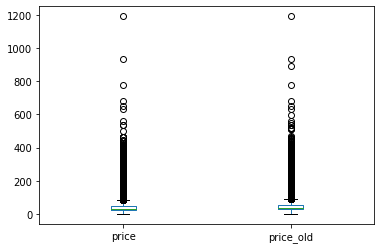

In [26]:
df[['price', 'price_old']].plot.box()

The IQR method is used by boxplots in order to display the shape of data. From what can be observed from the graphs above, using this method to remove the outliers will reduce the entries in dataset greatly. It's important to avoid disposing of data that is not an outlier, rather just an entry that is simply more expensive.

For this reason, z-score method seems to be the right method to implement. The entries too far from 0 are going to be detected as an outlier. The standard treshold will be applied (only entries with z-score fitting in range 3 and -3 will remain).

In [27]:
df_no_outliers = df[(abs(stats.zscore(df['price']))<3) & (abs(stats.zscore(df['price']))>-3)]
df_no_outliers = df_no_outliers[(abs(stats.zscore(df_no_outliers['price_old']))<3) & (abs(stats.zscore(df_no_outliers['price_old']))>-3)]

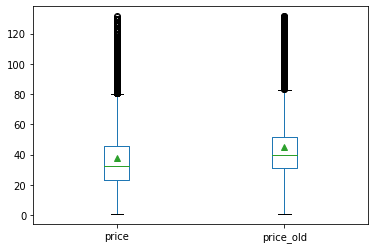

In [28]:
df_no_outliers[['price', 'price_old']].plot.box(showmeans=True)

In [29]:
df_no_outliers.describe()

,cover,ean,pages_count,price,price_old,isPolish,width,height
count,6.859800e+04,6.859800e+04,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000,68598.000000
mean,-2.140972e+08,9.377799e+12,269.391834,37.637600,45.148734,0.655486,16.516616,20.761577
std,6.433807e+08,1.727116e+12,181.507835,23.565125,24.114386,0.475213,4.446368,4.347001
min,-2.147484e+09,1.000000e+12,1.000000,0.720000,1.000000,0.000000,1.000000,0.500000
25%,0.000000e+00,9.781627e+12,128.000000,23.040000,31.000000,0.000000,13.500000,19.500000
50%,0.000000e+00,9.788327e+12,256.000000,32.500000,39.900000,1.000000,15.000000,20.500000
75%,1.000000e+00,9.788375e+12,384.000000,46.000000,51.900000,1.000000,19.500000,23.000000
max,1.000000e+00,9.997984e+12,2748.000000,131.500000,131.500000,1.000000,85.100000,98.000000


## Factors influencing the price

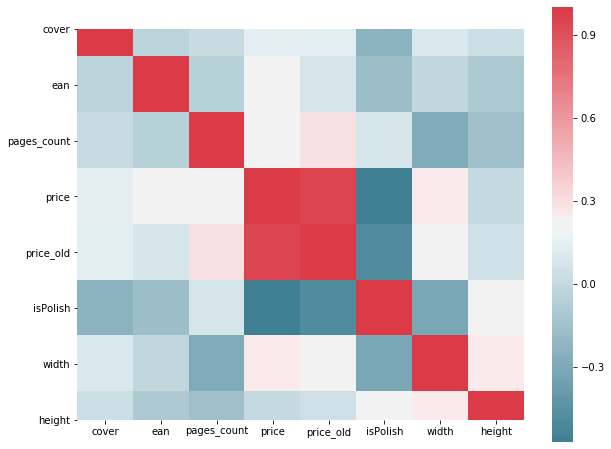

In [30]:
import seaborn as sns

f, ax = plt.subplots(figsize=(10, 8))
corr = df_no_outliers.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

As it can be observed in the heatmap above: 
* there is a strong negative correlation between price and whether book is Polish or not. 
* the former price and price are highly correlated, however as they cannot be treated independently this correlation is not taken into consideration. 
* there is a very small correlation between the price and the type of the cover or the size of the book. 
* the pages count seems to slightly influence the original prices, however this can no longer be observed with the prices after the discount.

In [31]:
pl = round(df_no_outliers[df_no_outliers.isPolish == 1]['price'].mean())
en = round(df_no_outliers[df_no_outliers.isPolish == 0]['price'].mean())
pl_o = round(df_no_outliers[df_no_outliers.isPolish == 1]['price_old'].mean())
en_o = round(df_no_outliers[df_no_outliers.isPolish == 0]['price_old'].mean())
print('Polish book mean price: {}, non-Polish book mean price: {}\nPolish book mean original price: {}, non-Polish book mean original price: {}'.format(pl, en, pl_o, en_o))

Polish book mean price: 28, non-Polish book mean price: 56
Polish book mean original price: 37, non-Polish book mean original price: 61


Next, the data will be grouped by the subject as it is another factor to be taken into consideration.

In [32]:
price_sub_mean = df_no_outliers[['price', 'price_old', 'subject']].groupby('subject').mean()
price_sub_mean['price_diff'] = price_sub_mean['price_old'] - price_sub_mean['price']

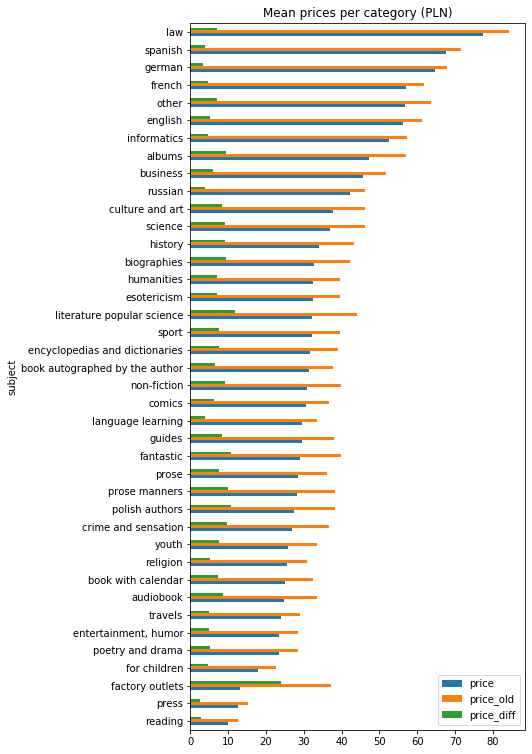

In [33]:
ax = price_sub_mean.sort_values('price').plot.barh(figsize=(6,13), title='Mean prices per category (PLN)')

The graph above shows the distribution of mean prices, gruped by the subject. The most expensive category is law, followed by Spanish and German. The cheapest ones are readings, press and books for children.

The biggest difference between the former price and current price can be observed in the outlets category (which is self-explanatory).

In [34]:
df_desc = df_no_outliers[['price', 'subject']].groupby('subject').agg({'price': [np.mean, np.std, len]}).rename(columns={'len':'count'})

In [35]:
def highlight_max(s):
    max_val = s.nlargest(3).values
    return ['background-color: #adedbe' if x in max_val else '' for x in s]

def highlight_min(s):
    min_val = s.nsmallest(3).values
    return ['background-color: #f7bfba' if x in min_val else '' for x in s]

df_desc.style.apply(highlight_max).apply(highlight_min)

Finally, as it can be observed in the table above, the subjects with the most extreme values are:

* Highest mean price: law, German, Spanish
* Highest standard deviation: Russian, Law, other
* Highest books count: English, books for children, prose



* Lowest mean price: reading, press, factory outlets
* Lowest standard deviation: books autographed by the author, books by polish authors, crime and sensation
* Lowest book count: Russian, books autographed by the author, other

While some categories have not enough entries to be deemed credible alone, it is evident that books written in foreign languages are generally more expensive than Polish ones. 

## Conclusions

The price is influenced by less factors than initially assumed. The most relevant ones are language and subject. This might be caused by the following:

* Some of the highest ranking subjects are generally considered to be some kind of specialistic knowledge (such as IT or business).
* Some of the subjects might be considered having intangible, artistic value, therefore easier to be priced higher.
* The books written in foreign languanges might have lower availibility in the Polish market, which allows the bookstore to hae a higher price spread for such books.